In [ ]:
# importing neccesary libraries
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Connect to your MySQL database
conn = mysql.connector.connect(
    host="35.199.22.103",
    user="gerardo-25intern",
    password= "Replay2025!",
    database="PlayerDev"
)

# Create a cursor object
cursor = conn.cursor()

# Write and execute your SQL query
query = "SELECT * FROM PlayerDev.HittingGold"

# Execute and fetch the data
cursor.execute(query)
rows = cursor.fetchall()
columns = cursor.column_names
df = pd.DataFrame(rows, columns=columns)

# Always close the cursor and connection
cursor.close()
conn.close()

In [ ]:
# Data Cleaning
metrics = [
    'metric_swing_speed',
    'metric_peak_hand_speed',
    'metric_power',
    'metric_rotational_acceleration',
    'metric_time_to_contact',
    'metric_bat_path_angle',
    'metric_vertical_bat_angle',
    'metric_connection_score',
    'metric_plane_score',
    'metric_early_connection',
    'SmashFactor',
    'SwingEfficiency',
    'Velo'
]

# Filter columns and drop rows with missing data in those columns
df_metrics = df[metrics].dropna()

# Convert object to integer or float
for col in metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df[metrics].dtypes)

metric_swing_speed                float64
metric_peak_hand_speed            float64
metric_power                      float64
metric_rotational_acceleration    float64
metric_time_to_contact            float64
metric_bat_path_angle               int64
metric_vertical_bat_angle           int64
metric_connection_score             int64
metric_plane_score                  int64
metric_early_connection             int64
SmashFactor                       float64
SwingEfficiency                   float64
Velo                              float64
dtype: object


Velo                              1.000000
SmashFactor                       0.969037
metric_swing_speed                0.212235
metric_power                      0.203071
metric_peak_hand_speed            0.148400
metric_bat_path_angle             0.132064
metric_rotational_acceleration    0.112774
SwingEfficiency                   0.083464
metric_connection_score          -0.002141
metric_early_connection          -0.003308
metric_vertical_bat_angle        -0.045119
metric_plane_score               -0.059288
metric_time_to_contact           -0.135798
Name: Velo, dtype: float64


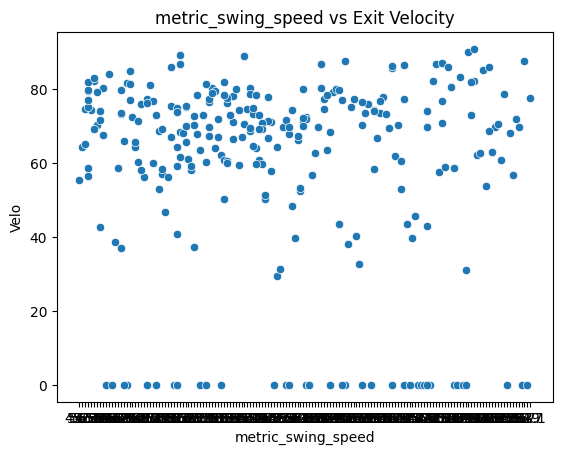

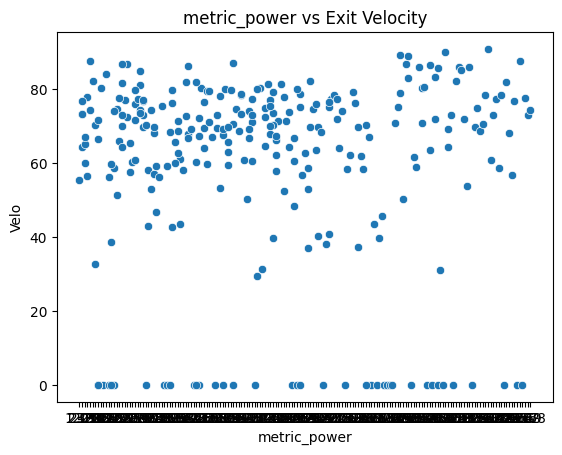

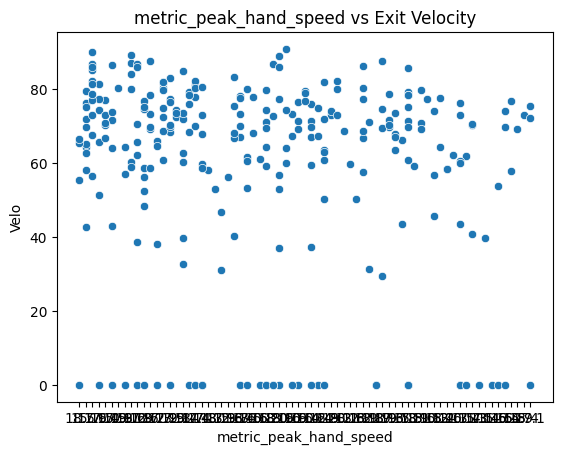

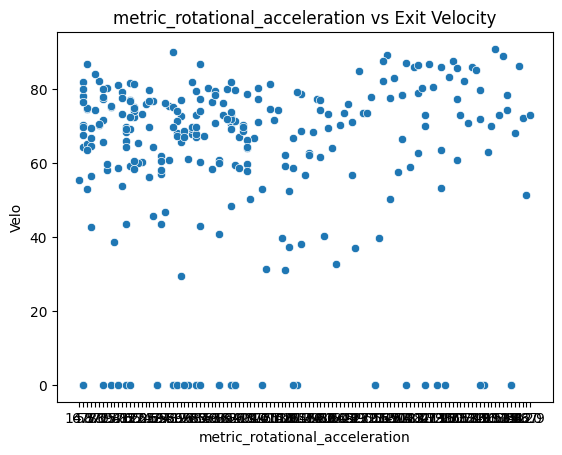

In [ ]:
# Exploritory Data Analysis

# Correlation
corr_matrix = df_metrics.corr()
print(corr_matrix['Velo'].sort_values(ascending=False))

# Plot top 4 metrics against Velo
top_metrics = ['metric_swing_speed', 'metric_power', 'metric_peak_hand_speed', 'metric_rotational_acceleration']

for metric in top_metrics:
    sns.scatterplot(data=df_metrics, x=metric, y='Velo')
    plt.title(f'{metric} vs Exit Velocity')
    plt.show()

In [ ]:
#Model Development for Swing Speed and Power


features = ['metric_swing_speed', 'metric_power']
X = df_metrics[features]       # predictors
y = df_metrics['Velo']         # target (exit velocity)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))

R² Score: 0.04306409829537927
RMSE: 24.273192426960247
Intercept: 1.8046707486154858
Coefficients: {'metric_swing_speed': np.float64(1.020988686168998), 'metric_power': np.float64(-0.39333305298992943)}


In [ ]:
# Test for Correlation

correlation = df_metrics[['metric_swing_speed', 'metric_power']].corr().iloc[0,1]
print(f"Correlation between metric_swing_speed and metric_power: {correlation:.3f}")

# VIF TESTING
X_vif = df_metrics[['metric_swing_speed', 'metric_power']].copy()
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')  # force bad values to NaN

X_vif.replace([np.inf, -np.inf], np.nan, inplace=True)
X_vif.dropna(inplace=True)

vif_data = []
for i in range(X_vif.shape[1]):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append(vif)

for feature, vif in zip(X_vif.columns, vif_data):
    print(f"VIF for {feature}: {vif:.2f}")

Correlation between metric_swing_speed and metric_power: 0.937
VIF for metric_swing_speed: 26.22
VIF for metric_power: 26.22


In [ ]:
# Model Development for Swing Speed

features = ['metric_swing_speed']
X = df_metrics[features]
y = df_metrics['Velo']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])

R² Score: 0.04377083131689219
RMSE: 24.2642274403262
Intercept: 3.448856798211324
Coefficient: 0.9750682169092724


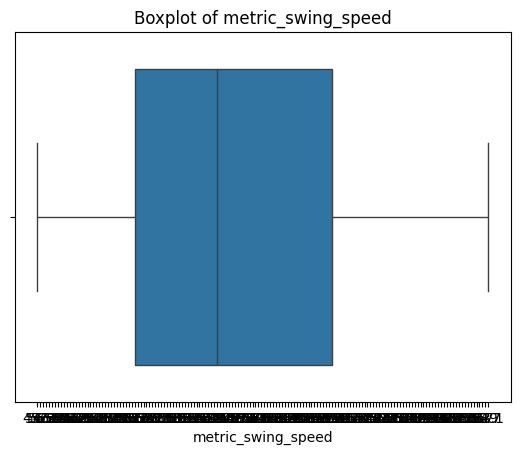

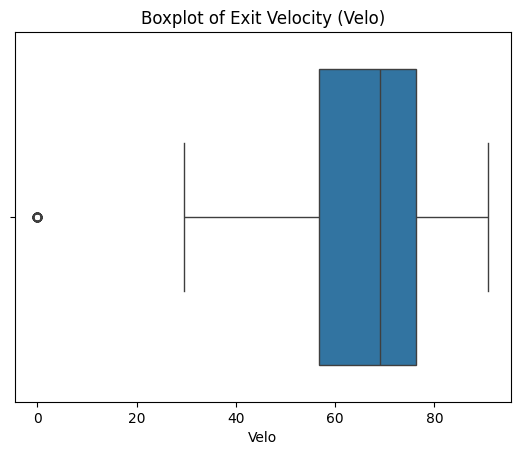

In [ ]:
# Boxplots to spot outliers
sns.boxplot(x=df_metrics['metric_swing_speed'])
plt.title('Boxplot of metric_swing_speed')
plt.show()

sns.boxplot(x=df_metrics['Velo'])
plt.title('Boxplot of Exit Velocity (Velo)')
plt.show()

In [ ]:
# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Convert to numeric (in case some values are strings like '89.5' or 'NaN')
df_metrics['metric_swing_speed'] = pd.to_numeric(df_metrics['metric_swing_speed'], errors='coerce')
df_metrics['Velo'] = pd.to_numeric(df_metrics['Velo'], errors='coerce')

# Drop rows with NaNs created by coercion
df_metrics.dropna(subset=['metric_swing_speed', 'Velo'], inplace=True)

# Now safely remove outliers
df_clean = remove_outliers(df_metrics, 'metric_swing_speed')
df_clean = remove_outliers(df_clean, 'Velo')

print(f"Original data size: {len(df_metrics)}")
print(f"Cleaned data size: {len(df_clean)}")


Original data size: 283
Cleaned data size: 238


In [ ]:
#Model Development with Clean Data
features = ['metric_swing_speed']
X = df_clean[features]
y = df_clean['Velo']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("After outlier removal:")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])

After outlier removal:
R² Score: 0.28055991947856296
RMSE: 11.085407716455082
Intercept: 6.301246253564713
Coefficient: 1.1002878345758627


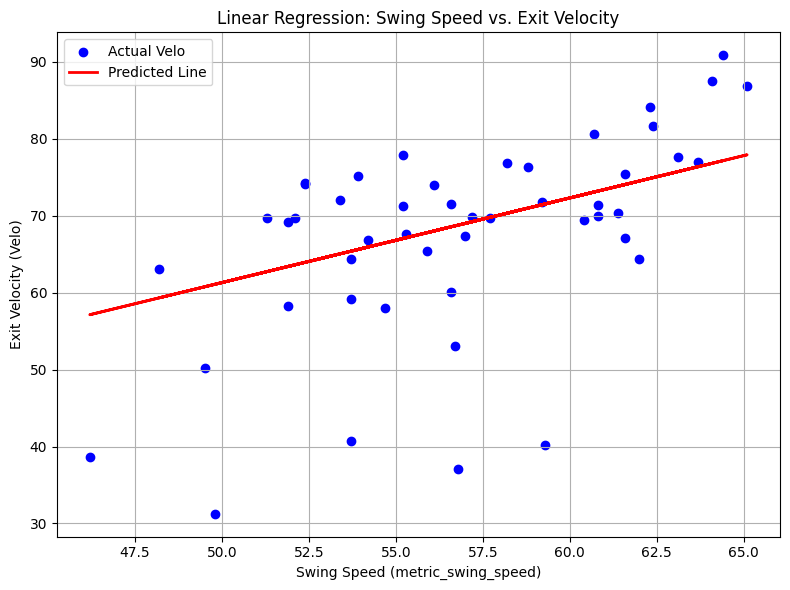

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Velo')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Line')

plt.title('Linear Regression: Swing Speed vs. Exit Velocity')
plt.xlabel('Swing Speed (metric_swing_speed)')
plt.ylabel('Exit Velocity (Velo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Model Development (Random Forest)

features = ['metric_swing_speed']
X = df_clean[features]
y = df_clean['Velo']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Random Forest Results:")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
importances = rf.feature_importances_
print(f"Feature importance for metric_swing_speed: {importances[0]:.3f}")

Random Forest Results:
R² Score: 0.12162109527629772
RMSE: 12.248849681032484
Feature importance for metric_swing_speed: 1.000


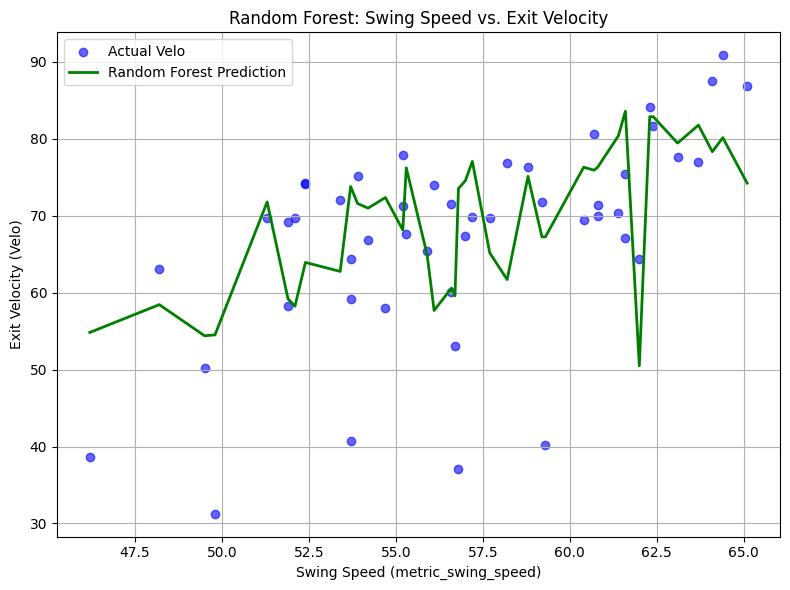

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort test data for a smooth prediction line
X_test_sorted = X_test.sort_values(by='metric_swing_speed')
y_pred_sorted = rf.predict(X_test_sorted)

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Velo', alpha=0.6)
plt.plot(X_test_sorted, y_pred_sorted, color='green', linewidth=2, label='Random Forest Prediction')

plt.title('Random Forest: Swing Speed vs. Exit Velocity')
plt.xlabel('Swing Speed (metric_swing_speed)')
plt.ylabel('Exit Velocity (Velo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Model Development (mutliple features)

# Function to remove outliers based on IQR for multiple columns
def remove_outliers_multi(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Features to use
features = ['metric_swing_speed', 'metric_bat_path_angle', 'metric_rotational_acceleration']

# Remove outliers from these features + target 'Velo'
cols_to_clean = features + ['Velo']
df_clean_new = remove_outliers_multi(df_metrics, cols_to_clean)

# Prepare data
X = df_clean_new[features]
y = df_clean_new['Velo']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Linear Regression Results with swing speed, bat path angle & rotational acceleration:")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))

TypeError: unsupported operand type(s) for -: 'str' and 'str'

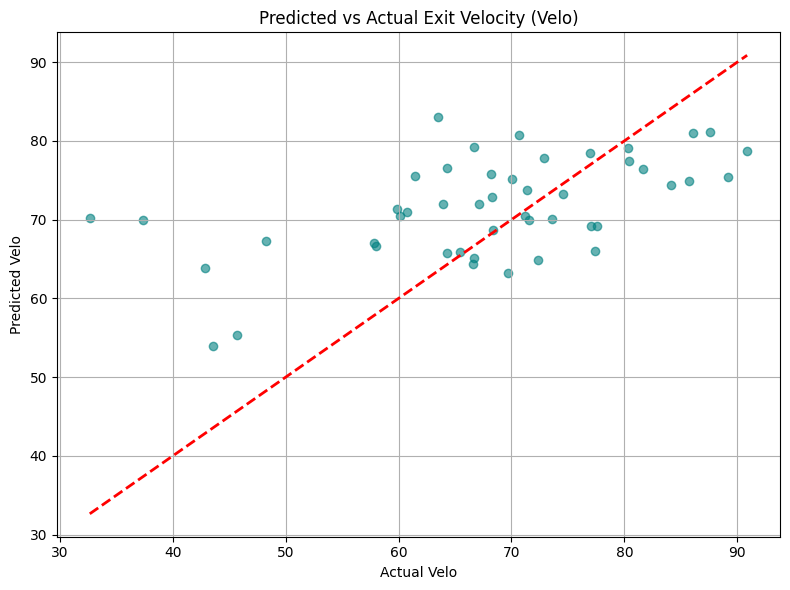

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Predicted vs Actual Exit Velocity (Velo)')
plt.xlabel('Actual Velo')
plt.ylabel('Predicted Velo')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Model Development (mutliple features)

# Function to remove outliers based on IQR for multiple columns
def remove_outliers_multi(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Features to use
features = ['metric_swing_speed', 'metric_power', 'metric_peak_hand_speed']

# Remove outliers from these features + target 'Velo'
cols_to_clean = features + ['Velo']
df_clean_new = remove_outliers_multi(df_metrics, cols_to_clean)

# Prepare data
X = df_clean_new[features]
y = df_clean_new['Velo']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Linear Regression Results with swing speed, power & peak hand speed:")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))

Linear Regression Results with swing speed, power & peak hand speed:
R² Score: 0.22726001614008406
RMSE: 11.511327090434962
Intercept: 32.96051994746861
Coefficients: {'metric_swing_speed': np.float64(0.6693744017802674), 'metric_power': np.float64(5.783314142019436), 'metric_peak_hand_speed': np.float64(-0.9080763213789744)}


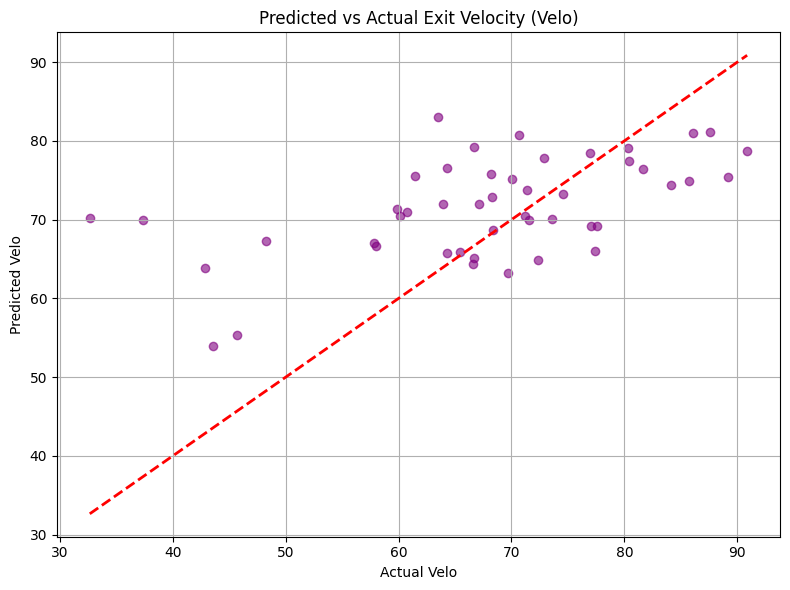

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Predicted vs Actual Exit Velocity (Velo)')
plt.xlabel('Actual Velo')
plt.ylabel('Predicted Velo')
plt.grid(True)
plt.tight_layout()
plt.show()